In [1]:
import numpy as np
import wandb
from tqdm import trange
from util.mnist.tools import *
from util.pickleInterface import *
from util.whatwhere.encoder import *
from util.whatwhere.decoder import *
from util.whatwhere.noise import *
from util.willshaw.memory import *
from util.willshaw.plot import *
from util.pytorch.tools import np_to_grid
from util.kldiv import *
from util.basic_utils import mse_detailed
from util.whatwhere.description_encoding import *

In [2]:
""" load mnist """
imgs, lbls, _, _ = read_mnist(n_train=60000)
I = imgs.shape[1]
J = imgs.shape[2]

In [3]:
""" Code generation parameters """
rng = np.random.RandomState(0)  # reproducible
K = 20
Q = 21
n_epochs = 5
b = 0.8
wta = True
Fs = 2
T_what = 0.9

""" generate codes """
features = compute_features(imgs, lbls, K, Fs, rng, n_epochs, b, verbose=False)
codes, polar_params = compute_codes(
    imgs,
    K,
    Q,
    features,
    T_what,
    wta,
    n_epochs,
    b,
    Fs,
    verbose=False,
)

code_size = codes.shape[1]

In [6]:
from util.whatwhere.create import *

In [10]:
gen_lbls = np.tile(np.arange(10), 10)
print(gen_lbls)

[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


In [20]:
""" Desc params"""
x =100
Pc = 0.5
Pr = 0.0

descs = noisy_x_hot_encoding(lbls, x, Pc, Pr)
gen_descs = noisy_x_hot_encoding(gen_lbls, x, Pc, Pr)
desc_size = descs.shape[1]

In [21]:
def plot_class_act(descs, lbls, c):
    s = np.mean(descs[lbls == c], axis=0)
    plt.bar(np.arange(s.shape[0]), s)

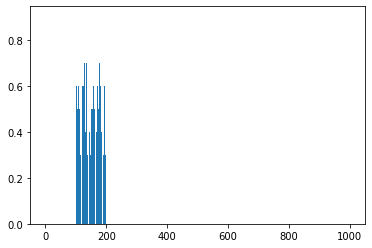

In [22]:
plot_class_act(gen_descs, gen_lbls, 1)

In [23]:
desCodes = concatenate(descs, codes)

In [24]:
mem = AAWN(desc_size + code_size)
mem.store(desCodes)

In [25]:
ret = mem.retrieve(desCodes)

In [27]:
dist_cod = np.zeros((10, code_size))
dist_ret = np.zeros((10, code_size))

for c in range(10):
    dist_cod[c] = compute_prob_dist(codes[lbls==c])
    dist_ret[c] = compute_prob_dist(codes[lbls==c])

In [34]:
sample_cod = np.zeros((100, code_size))
sample_ret = np.zeros((100, code_size))

for c in range(10):
    sample_cod[c*10:(c+1)*10] = sample_from_dist(dist_cod[c], n=10).toarray().reshape(10,code_size)
    sample_ret[c*10:(c+1)*10] = sample_from_dist(dist_ret[c], n=10).toarray().reshape(10,code_size)

sample_cod_wn = mem.retrieve(csr_matrix(sample_cod))

ValueError: dimension mismatch